
**Poverty Prediction Using PSLM-2020 Dataset**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load PSLM-2020 datasets
df_secE = pd.read_csv("/content/SecE.csv")
df_secb2 = pd.read_csv("/content/secb2.csv")

# Merge secE and secb2 datasets on 'hhcode'
df = pd.merge(df_secE, df_secb2, on="hhcode", how="inner")

# Rename PSLM-coded columns to meaningful names
df.rename(columns={
    "seaq08": "monthly_income",
    "seaq10": "annual_income",
    "seaq21": "pension_income",
    "seaq23": "income_inside_pakistan",
    "seaq24": "foreign_remittances",
    "seaq25": "rent_income",
    "seaq26": "other_income"
}, inplace=True)

# Ensure 'monthly_income' exists, otherwise estimate it
df['monthly_income'] = df.get('monthly_income', df.get('annual_income', 0) / 12)

df['monthtoannual'] = df['monthly_income'] * 12

# Define relevant income columns
income_features = ['pension_income', 'income_inside_pakistan', 'foreign_remittances', 'rent_income', 'other_income', 'annual_income', 'monthtoannual']

# Check which columns exist and filter only those
existing_income_features = [col for col in income_features if col in df.columns]
df[existing_income_features] = df[existing_income_features].apply(pd.to_numeric, errors='coerce').fillna(0)

df['total_income'] = df[existing_income_features].sum(axis=1)
df['daily_income'] = df['total_income'] / 365

# Reduce memory usage
df['daily_income'] = df['daily_income'].astype(np.float32)

daily_income_mean = df.groupby('hhcode', as_index=False)['daily_income'].mean()
df = df.merge(daily_income_mean, on='hhcode', suffixes=('', '_mean'))

# Define Poverty Status based on World Bank Criteria
poverty_line = 2.15 * 279
df['poverty_status'] = np.where(df['daily_income_mean'] < poverty_line, 'Below Poverty', 'Above Poverty')

# Define independent and dependent variables
X = df.drop(columns=["poverty_status", "hhcode"], errors='ignore')
y = df["poverty_status"]


In [4]:
# Identify numerical and categorical features
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocessing pipeline with missing value handling
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

In [5]:
# Train multiple models
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for model_name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        "accuracy": accuracy,
        "report": report,
        "confusion_matrix": cm
    }


Model: RandomForest
Accuracy: 1.00
Classification Report:
                precision    recall  f1-score   support

Above Poverty       1.00      1.00      1.00      3431
Below Poverty       1.00      1.00      1.00     74155

     accuracy                           1.00     77586
    macro avg       1.00      1.00      1.00     77586
 weighted avg       1.00      1.00      1.00     77586

Confusion Matrix:
 [[ 3429     2]
 [    0 74155]]
--------------------------------------------------
Model: GradientBoosting
Accuracy: 1.00
Classification Report:
                precision    recall  f1-score   support

Above Poverty       1.00      1.00      1.00      3431
Below Poverty       1.00      1.00      1.00     74155

     accuracy                           1.00     77586
    macro avg       1.00      1.00      1.00     77586
 weighted avg       1.00      1.00      1.00     77586

Confusion Matrix:
 [[ 3431     0]
 [    0 74155]]
--------------------------------------------------


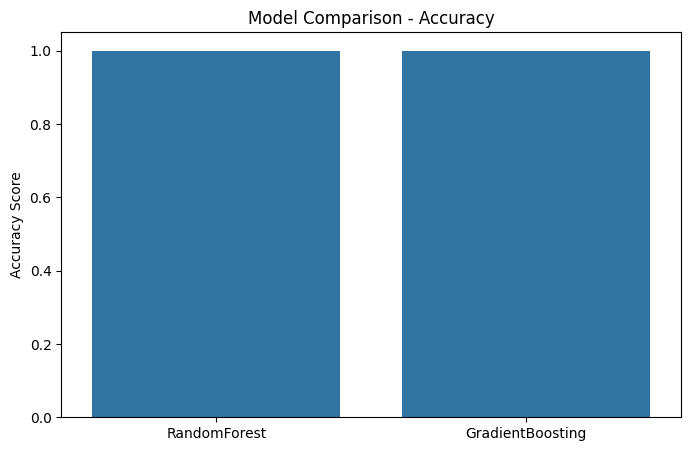

In [6]:
# Print results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['accuracy']:.2f}")
    print("Classification Report:\n", metrics['report'])
    print("Confusion Matrix:\n", metrics['confusion_matrix'])
    print("-" * 50)

# Visualization
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=[metrics['accuracy'] for metrics in results.values()])
plt.title("Model Comparison - Accuracy")
plt.ylabel("Accuracy Score")
plt.show()